In [7]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __radd__(self, other): # other + self
        return self + other


    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        #we could define exp and div functions and use them
        #but we don't need to -- we can use higher abstractions
        #all we need is to be able to compute the operator
        #and its derivative
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def my_backward(self):
        #root node grad must be manually set to 1.0 first
        self._backward()
        for child in self._prev:
            child.my_backward()
    
    def backward(self):
        # topological sort
        # lays out nodes so that all edges go only in one direction
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) #maintains invariant, since v is only
                               #appended AFTER all of its children
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [50]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [24]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [68]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b') #magic constant so numbers come out nice
# SUM(x_i*w_i) + b
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

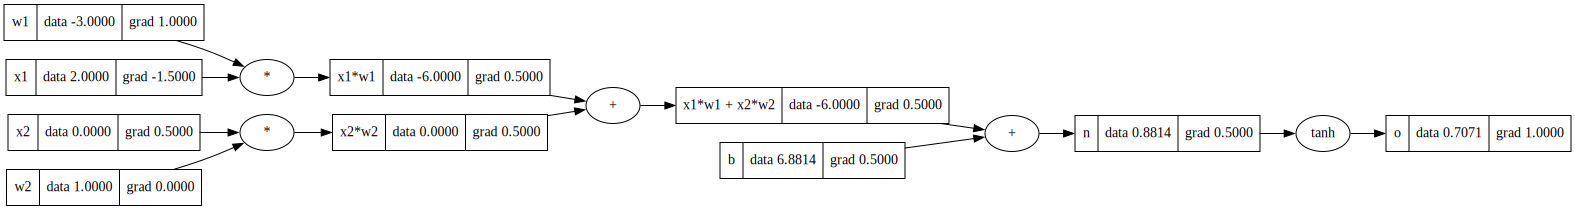

In [69]:
draw_dot(o)

In [74]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b') #magic constant so numbers come out nice
# SUM(x_i*w_i) + b
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()

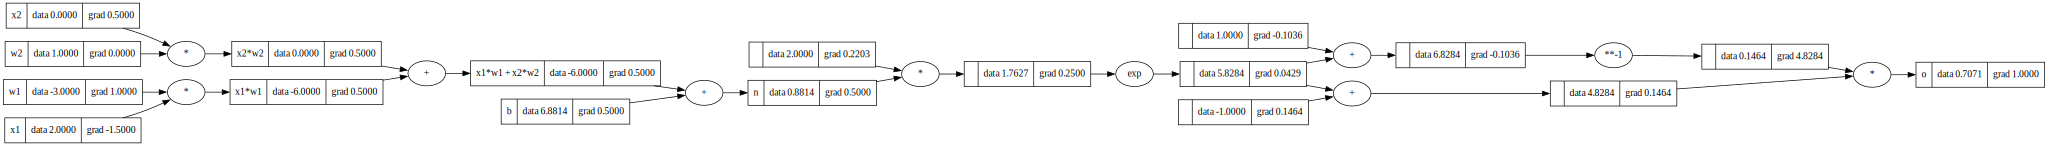

In [75]:
draw_dot(o)

In [79]:
#now, the same thing, with PyTorch

import torch

x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [81]:
torch.Tensor([2.0]).dtype

torch.float32

In [83]:
x1.dtype #.double() makes it float64 (⌒‿⌒)

torch.float64

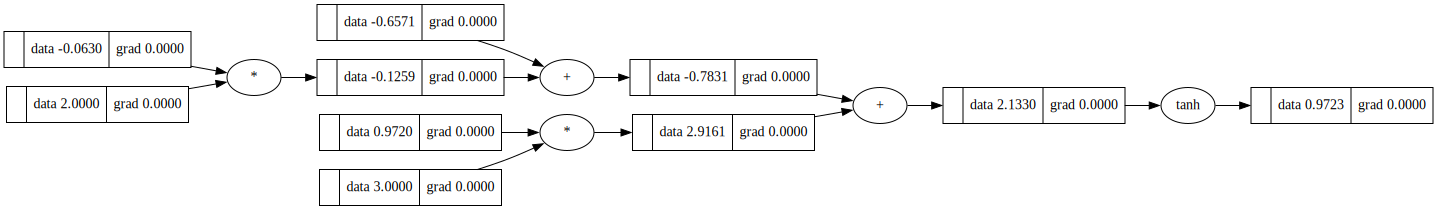

In [73]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

x = [2.0, 3.0]
n = Neuron(2)
n(x)
draw_dot(n(x))

In [74]:
class Layer:
    def __init__(self, nin, nout): # nin is #inputs per neuron, nout is #neurons
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs #convenience
    
    def parameters(self):
        #we could write:
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #return params
        #but, that's too much code!!!
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #shorter!!
        #but IDGI... lel

n = Layer(2, 3)
n(x)

#basically, a Layer is just a type (/"class") which contains a list of Neurons
#draw_dot(n(x)[0])

[Value(data=0.9531081252365183),
 Value(data=-0.9978412078324613),
 Value(data=0.9985311789316318)]

In [172]:
class MLP:
    def __init__(self, nin, nouts): #nouts is list of output size for every layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [173]:
nparams = n.parameters()
print(len(nparams))
nparams

41


[Value(data=-2.2913981687788388e+49),
 Value(data=-1.398510500608473e+49),
 Value(data=-6.339893664329499e+48),
 Value(data=-1.5535798853051968e+49),
 Value(data=1.01669681649204e+50),
 Value(data=6.426502955586561e+49),
 Value(data=-8.930981845654464e+48),
 Value(data=2.1401770598393029e+49),
 Value(data=-2.902007052912652e+46),
 Value(data=5.896363854664781e+45),
 Value(data=-1.0970168526509275e+45),
 Value(data=-3.7738116581477695e+45),
 Value(data=-4.972396572849305e+46),
 Value(data=3.6807983717284204e+45),
 Value(data=-2.4152749492206645e+45),
 Value(data=-8.984591243427975e+45),
 Value(data=-1.4137342004798234e+25),
 Value(data=-1.8555387347718488e+24),
 Value(data=-9.824557444424405e+23),
 Value(data=-2.1041213376988625e+23),
 Value(data=-3.2808082953527635e+24),
 Value(data=6.073674332324474e+23),
 Value(data=5.4749538954509975e+22),
 Value(data=3.104904817071903e+22),
 Value(data=6.393256656015589e+21),
 Value(data=1.34032893786025e+23),
 Value(data=-2.4760255946919173e+20),


In [174]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9492847833731075)

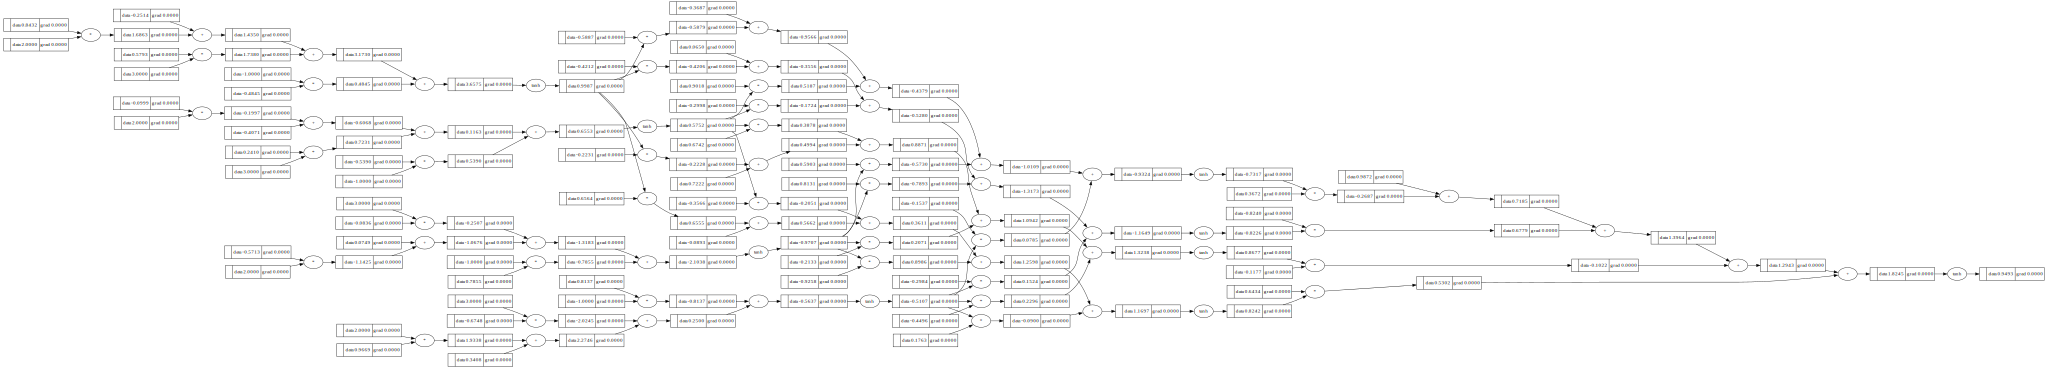

In [175]:
draw_dot(n(x))

In [176]:
#manual "MLP" build out of layers for sanity check
lyr1 = Layer(3, 4)
lyr2 = Layer(4, 4)
lyr3 = Layer(4, 1)

x = [2.0, 3.0, -1.0]
print(x)

lyr1_out = lyr1(x)
print(lyr1_out)

lyr2_out = lyr2(x)
print(lyr2_out)

lyr3_out = lyr3(x)
print(lyr3_out)

#I was basically wondering how MLP actually *connects* the layers together. i.e., how does MLP know which neurons'
#outputs connect to which neurons' inputs across layers
#it turns out, the layers are not really "connected" as shown in diagrams
#rather, a given layer takes a vector of inputs, and applies that vector on each of its neurons,
#and produces a vector of outputs containing the result of application of the input vector to each neuron
#this is "connected" just because all neurons's results in one layer get fed as inputs to the neurons in the next layer

#it's not really like
# 0 1 2 3
#   O-O
#  / X \
# O-O-O-O
#  \ X /
#   O-O
#it's actually like
# 0 1 2 3
# O-O-O-O

[2.0, 3.0, -1.0]
[Value(data=0.7740160129367432), Value(data=0.9998025278506943), Value(data=0.9968172383999835), Value(data=0.9917986304387265)]
[Value(data=-0.9997627131249313), Value(data=0.30008159175911336), Value(data=-0.6899594593210321), Value(data=-0.9994010604415275)]
Value(data=-0.9995082915736884)


In [177]:
#example dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9492847833731075),
 Value(data=0.9566809337886527),
 Value(data=0.47418809996368616),
 Value(data=0.9451683779945377)]

In [178]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.0074093706958385)

In [179]:
loss.backward()

In [180]:
n.layers[0].neurons[0].w[0].grad

0.7504935870571984

In [181]:
n.layers[0].neurons[0].w[0].data

0.8431736408999668

In [182]:
#draw_dot(loss)

In [183]:
# COMMENCING GRADIENT DESCENT ............
# think of gradient as a vector pointing in the direction of
# increased loss
# however, we want to decrease loss
# so we add a small negative percentage of the gradient!
for p in n.parameters():
    p.data += -0.01 * p.grad

In [184]:
n.layers[0].neurons[0].w[0].data

0.8356687050293948

In [185]:
#calculate loss after gradient descent
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.561701924191906)

In [186]:
ypred

[Value(data=0.9452830323679229),
 Value(data=0.9502390507152992),
 Value(data=0.32350403895176644),
 Value(data=0.9398944130009104)]

In [187]:
#now lets iterate!!!
for _ in range(0, 100):
    loss.backward()
    for p in n.parameters():
        p.data += -0.01 * p.grad
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

print(loss)
ypred

Value(data=5.176505463438482e-22)


[Value(data=0.9999999999839418),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999999999838821)]

In [211]:
# reinitialize network
n = MLP(3, [4, 4, 1])
n(x)
# training data
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [212]:
# "proper" training loop
for k in range(1000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters(): #zero_grad()
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)

0 7.3880578430991415
1 6.592222017864415
2 5.723438805332009
3 4.791365524817783
4 3.8409864900845005
5 2.9849528870880695
6 2.326149112460812
7 1.869585272614465
8 1.5585485746852592
9 1.3388346126019692
10 1.1758485518068662
11 1.0495692003206143
12 0.9483087707155101
13 0.8649393368742281
14 0.7948869264145249
15 0.7350728767040965
16 0.6833372725603786
17 0.638111009907001
18 0.5982206581275833
19 0.5627672703843231
20 0.5310481419242498
21 0.5025045280720023
22 0.47668563938917347
23 0.4532231859288627
24 0.4318129629209748
25 0.4122012611625676
26 0.39417466071049523
27 0.3775522462707534
28 0.3621795878335491
29 0.34792402907847236
30 0.3346709587809226
31 0.32232083079097346
32 0.31078676080655365
33 0.2999925723485226
34 0.2898711959885141
35 0.28036334885960706
36 0.27141643838108426
37 0.2629836467053778
38 0.25502316185513696
39 0.24749752870453398
40 0.24037309846813493
41 0.2336195596203277
42 0.22720953648799147
43 0.22111824436545585
44 0.21532319206128844
45 0.20980392

348 0.020653760391477802
349 0.0205890085256354
350 0.020524651024947896
351 0.02046068434636972
352 0.020397104988800582
353 0.02033390949247078
354 0.02027109443833649
355 0.020208656447486158
356 0.020146592180556963
357 0.020084898337161556
358 0.02002357165532443
359 0.019962608910928215
360 0.019902006917169465
361 0.01984176252402348
362 0.01978187261771885
363 0.019722334120220314
364 0.01966314398872073
365 0.019604299215141726
366 0.01954579682564248
367 0.019487633880137065
368 0.01942980747181969
369 0.019372314726698116
370 0.019315152803134603
371 0.019258318891394653
372 0.019201810213203423
373 0.01914562402130897
374 0.019089757599053275
375 0.019034208259950086
376 0.01897897334726965
377 0.018924050233630394
378 0.01886943632059712
379 0.018815129038285836
380 0.018761125844975232
381 0.018707424226723994
382 0.01865402169699456
383 0.0186009157962832
384 0.018548104091755557
385 0.01849558417688836
386 0.018443353671116804
387 0.01839141021948753
388 0.0183397514923

744 0.009093771114388503
745 0.009080761487358018
746 0.009067788424685792
747 0.00905485177377955
748 0.009041951382890144
749 0.009029087101105716
750 0.009016258778345948
751 0.009003466265356367
752 0.008990709413702773
753 0.008977988075765522
754 0.008965302104734028
755 0.008952651354601248
756 0.008940035680158245
757 0.008927454936988675
758 0.00891490898146351
759 0.008902397670735574
760 0.00888992086273443
761 0.008877478416160944
762 0.008865070190482247
763 0.008852696045926388
764 0.008840355843477409
765 0.008828049444870078
766 0.008815776712584994
767 0.008803537509843503
768 0.008791331700602738
769 0.008779159149550787
770 0.008767019722101612
771 0.008754913284390469
772 0.008742839703268867
773 0.008730798846299997
774 0.008718790581753812
775 0.008706814778602535
776 0.008694871306515844
777 0.008682960035856292
778 0.008671080837674863
779 0.008659233583706146
780 0.008647418146364157
781 0.008635634398737614
782 0.008623882214585633
783 0.008612161468333282
784

In [213]:
ypred

[Value(data=0.9611176990968385),
 Value(data=-0.9748110875809396),
 Value(data=-0.9466198605795653),
 Value(data=0.9593090111908342)]